# [Hands-On] LSTM을 활용한 판독문 분류

- Author: Sangkeun Jung (hugmanskj@gmail.com)

> 교육 목적

**Copyright**: All rights reserved

---

## 개요

의료 판독문 텍스트를 **LSTM**으로 분류합니다.

**데이터셋**: 1,275건의 의료 판독문 (흉부, 복부, 뇌, 심장 등)

**실습 내용**:
1. Word-level Tokenization (공백 기반)
2. LSTM 모델 구축 (PyTorch)
3. 모델 학습 및 성능 평가
4. 학습 과정 시각화
5. Hidden States 분석
6. 전통적 ML 모델과 비교

**핵심 개념**:
- Word Tokenization: 공백 기반으로 단어 분리
- LSTM: 순환 신경망으로 시퀀스 패턴 학습
- Hidden States: LSTM의 마지막 은닉 상태를 분류에 활용

---

## 1. 데이터 다운로드 및 환경 설정

In [ ]:
# Colab 환경 체크 및 데이터 다운로드
import os
import sys

# Colab 환경인지 확인
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Google Colab 환경 감지")

    # 데이터 파일이 없으면 다운로드
    if not os.path.exists('medical_reports.tsv'):
        print("데이터 파일 다운로드 중...")

        # Dropbox 링크를 직접 다운로드 가능한 URL로 변경
        url = "https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1"

        !wget -O medical_reports.tsv "{url}"

        print("✓ 데이터 다운로드 완료!")
    else:
        print("✓ 데이터 파일이 이미 존재합니다.")

    # 한글 폰트 설정
    print("한글 폰트 설정 중...")
    !wget -q -O NanumGothic.ttf "https://www.dropbox.com/scl/fi/uehvji0snykblsv66erj2/NanumGothic.ttf?rlkey=c4et2h36iisxdp7dsjma6qluw&dl=1"

    import warnings
    import matplotlib as mpl
    import matplotlib.font_manager as fm

    path = "NanumGothic.ttf"
    if os.path.exists(path) and os.path.getsize(path) > 100_000:
        fm.fontManager.addfont(path)
        family_name = fm.FontProperties(fname=path).get_name()
        mpl.rcParams["font.family"] = family_name
    mpl.rcParams["axes.unicode_minus"] = False
    warnings.filterwarnings("ignore")

    print("✓ 한글 폰트 설정 완료!")

else:
    print("로컬 환경에서 실행 중")

Google Colab 환경 감지
데이터 파일 다운로드 중...
--2025-11-14 10:46:35--  https://www.dropbox.com/scl/fi/pxgyowomz59q8xdyk8x29/medical_reports.tsv?rlkey=4gcd8ffm53tpoyzicgry4pyqb&st=mq3c2w38&dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc58057c00eb959b0364fe33613c.dl.dropboxusercontent.com/cd/0/inline/C1JT0XvqztrFtgogwPOolKVzlhoMiQYwIc1mz85nMeYcn2EnEOP82KfLonaEKeYbaGllqpGfGvx4D8M2YysXNEzVXoCczqATjqD6ZOT5emJYTRo_Ca3fxHXq6gN5HCDi1Ls/file?dl=1# [following]
--2025-11-14 10:46:35--  https://uc58057c00eb959b0364fe33613c.dl.dropboxusercontent.com/cd/0/inline/C1JT0XvqztrFtgogwPOolKVzlhoMiQYwIc1mz85nMeYcn2EnEOP82KfLonaEKeYbaGllqpGfGvx4D8M2YysXNEzVXoCczqATjqD6ZOT5emJYTRo_Ca3fxHXq6gN5HCDi1Ls/file?dl=1
Resolving uc58057c00eb959b0364fe33613c.dl.dropboxusercontent.com (uc58057c00eb959b0364fe33613c.dl.dropboxusercontent

## 2. 라이브러리 로드

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple
import time
from collections import Counter

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

# scikit-learn (비교용)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix
)

# 한글 폰트 설정
if IN_COLAB:
    plt.rcParams['font.family'] = 'NanumGothic'
else:
    try:
        plt.rcParams['font.family'] = 'NanumGothic'
    except:
        print("⚠ 한글 폰트가 없어 기본 폰트를 사용합니다.")

plt.rcParams['axes.unicode_minus'] = False

# GPU 사용 가능 여부 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 장치: {device}")

print("라이브러리 로드 완료!")

사용 장치: cuda
라이브러리 로드 완료!


## 3. 데이터 로드 및 탐색

In [ ]:
# 데이터 로드
if IN_COLAB:
    data_path = 'medical_reports.tsv'
else:
    data_path = '../../../data/medical_reports.tsv'

df = pd.read_csv(data_path, sep='\t')

print(f"데이터 크기: {len(df):,}건")
print(f"\n카테고리별 분포:")
print(df['category'].value_counts())

데이터 크기: 1,275건

카테고리별 분포:
category
정상        491
경과관찰      455
즉시치료필요    171
추가검사필요    158
Name: count, dtype: int64


데이터 전처리

전처리 후 데이터: 1,275건

텍스트 길이 통계:
  평균: 70.0 문자
  최소: 39 문자
  최대: 123 문자
  중위: 67.0 문자


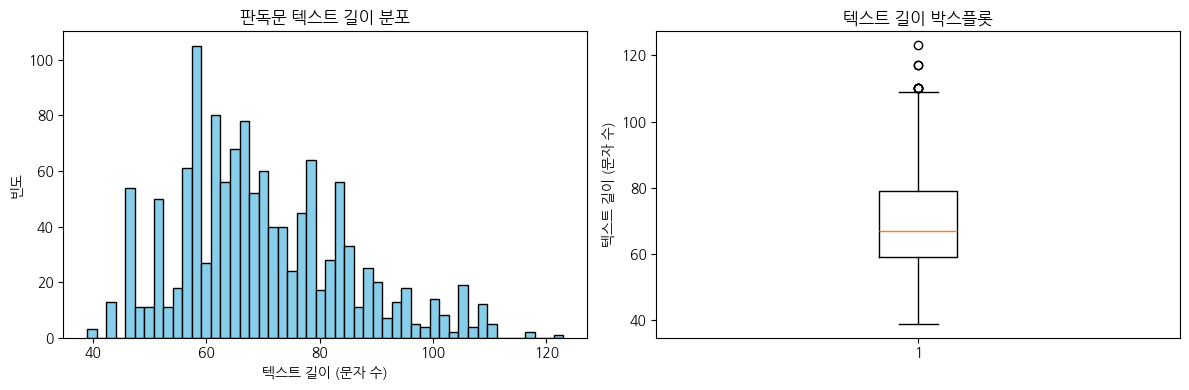

In [ ]:
# 데이터 전처리
print("=" * 70)
print("데이터 전처리")
print("=" * 70)

# 필요한 컬럼만 선택
df_clean = df[['findings', 'impression', 'category']].dropna()

# 텍스트 결합
df_clean['text'] = df_clean['findings'] + ' ' + df_clean['impression']

print(f"\n전처리 후 데이터: {len(df_clean):,}건")

# 텍스트 길이 분포 확인
text_lengths = df_clean['text'].apply(len)
print(f"\n텍스트 길이 통계:")
print(f"  평균: {text_lengths.mean():.1f} 문자")
print(f"  최소: {text_lengths.min()} 문자")
print(f"  최대: {text_lengths.max()} 문자")
print(f"  중위: {text_lengths.median():.1f} 문자")

# 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(text_lengths, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('텍스트 길이 (문자 수)')
plt.ylabel('빈도')
plt.title('판독문 텍스트 길이 분포')

plt.subplot(1, 2, 2)
plt.boxplot(text_lengths)
plt.ylabel('텍스트 길이 (문자 수)')
plt.title('텍스트 길이 박스플롯')

plt.tight_layout()
plt.show()

---

## 4. Word-level Tokenization

**Word Tokenization의 특징**:
- 공백 기반으로 **단어 단위** 처리
- 단어 의미를 직접 학습
- Character보다 짧은 시퀀스
- 빠른 학습 속도

**구현 단계**:
1. 전체 텍스트에서 고유 단어 추출
2. 단어 → 인덱스 매핑 사전 생성
3. 텍스트를 인덱스 시퀀스로 변환

In [ ]:
print("=" * 70)
print("Word Vocabulary 구축")
print("=" * 70)

# 전체 텍스트에서 단어 추출 (공백 기반)
all_words = set()
for text in df_clean['text']:
    words = text.split()  # 공백으로 분리
    all_words.update(words)

# 특수 토큰 추가
special_tokens = ['<PAD>', '<UNK>']
all_words = sorted(list(all_words))

# 단어 → 인덱스 매핑
word2idx = {word: idx + len(special_tokens) for idx, word in enumerate(all_words)}
word2idx['<PAD>'] = 0
word2idx['<UNK>'] = 1

# 인덱스 → 단어 매핑 (역방향)
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(word2idx)

print(f"\nVocabulary 크기: {vocab_size}")
print(f"\n단어 샘플 (처음 20개):")
sample_words = list(all_words)[:20]
print(sample_words)

print(f"\n특수 토큰:")
print(f"  <PAD>: {word2idx['<PAD>']}")
print(f"  <UNK>: {word2idx['<UNK>']}")

Word Vocabulary 구축

Vocabulary 크기: 889

단어 샘플 (처음 20개):
['(미세석회화', '-0.3로', '-0.4로', '-0.5,', '-0.5로', '-0.6,', '-0.6로', '-0.7,', '-0.7로', '-0.8,', '-0.8로', '-0.9,', '-1.0,', '-1.0로', '-1.2,', '-1.3로', '-1.4로', '-1.5,', '-1.5로', '-1.6,']

특수 토큰:
  <PAD>: 0
  <UNK>: 1


In [ ]:
# 텍스트 → 인덱스 시퀀스 변환 함수
def text_to_sequence(text: str, word2idx: Dict, max_len: int = None) -> List[int]:
    """텍스트를 인덱스 시퀀스로 변환"""
    words = text.split()  # 공백으로 분리
    sequence = [word2idx.get(word, word2idx['<UNK>']) for word in words]

    # 최대 길이 제한
    if max_len is not None:
        sequence = sequence[:max_len]

    return sequence

# 테스트
sample_text = df_clean['text'].iloc[0]
sample_sequence = text_to_sequence(sample_text, word2idx)

print("\n텍스트 → 시퀀스 변환 예시:")
print(f"원본: {sample_text[:100]}...")
print(f"시퀀스 (처음 20개): {sample_sequence[:20]}")
print(f"복원: {' '.join([idx2word[idx] for idx in sample_sequence[:20]])}")


텍스트 → 시퀀스 변환 예시:
원본: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도 정상입니다. 정상 흉부 X-ray 소견입니다....
시퀀스 (처음 20개): [573, 834, 670, 311, 554, 790, 681, 428, 692, 412, 884, 290, 686, 681, 885, 205, 508]
복원: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 종격동 및 흉벽 구조물도 정상입니다. 정상 흉부 X-ray 소견입니다.


## 5. 데이터셋 준비

PyTorch Dataset과 DataLoader를 구축합니다.

In [ ]:
print("=" * 70)
print("Train/Test 분할")
print("=" * 70)

# 레이블 인코딩
label2idx = {label: idx for idx, label in enumerate(sorted(df_clean['category'].unique()))}
idx2label = {idx: label for label, idx in label2idx.items()}

print(f"\n레이블 매핑:")
for label, idx in label2idx.items():
    print(f"  {label}: {idx}")

# 데이터 분할
X_texts = df_clean['text'].values
y_labels = df_clean['category'].map(label2idx).values

X_train_texts, X_test_texts, y_train, y_test = train_test_split(
    X_texts, y_labels,
    test_size=0.2,
    random_state=42,
    stratify=y_labels
)

print(f"\nTrain 데이터: {len(X_train_texts):,}건")
print(f"Test 데이터: {len(X_test_texts):,}건")

Train/Test 분할

레이블 매핑:
  경과관찰: 0
  정상: 1
  즉시치료필요: 2
  추가검사필요: 3

Train 데이터: 1,020건
Test 데이터: 255건


In [ ]:
# PyTorch Dataset 정의
class WordDataset(Dataset):
    """Word-level Dataset"""

    def __init__(self, texts, labels, word2idx, max_len=100):
        self.texts = texts
        self.labels = labels
        self.word2idx = word2idx
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # 텍스트를 시퀀스로 변환
        sequence = text_to_sequence(text, self.word2idx, self.max_len)

        return torch.LongTensor(sequence), torch.LongTensor([label])

# Collate 함수 (배치 내에서 패딩)
def collate_fn(batch):
    """배치를 패딩하여 동일한 길이로 만듦"""
    sequences, labels = zip(*batch)

    # 패딩
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)
    labels = torch.cat(labels)

    return sequences_padded, labels

In [ ]:
print("=" * 70)
print("DataLoader 생성")
print("=" * 70)

# 시퀀스 길이 분석
seq_lengths = [len(text.split()) for text in X_train_texts]
print(f"\n단어 시퀀스 길이 통계:")
print(f"  평균: {np.mean(seq_lengths):.1f} 단어")
print(f"  중위: {np.median(seq_lengths):.1f} 단어")
print(f"  최대: {np.max(seq_lengths)} 단어")
print(f"  최소: {np.min(seq_lengths)} 단어")

# 최대 길이 설정 (95 percentile 사용)
MAX_LEN = int(np.percentile(seq_lengths, 95))
print(f"\n최대 길이 설정 (95 percentile): {MAX_LEN} 단어")

# Dataset 생성
train_dataset = WordDataset(X_train_texts, y_train, word2idx, max_len=MAX_LEN)
test_dataset = WordDataset(X_test_texts, y_test, word2idx, max_len=MAX_LEN)

# DataLoader 생성
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn
)

print(f"\nDataLoader 설정:")
print(f"  Batch size: {BATCH_SIZE}")
print(f"  Max length: {MAX_LEN}")
print(f"  Train batches: {len(train_loader)}")
print(f"  Test batches: {len(test_loader)}")

# 배치 확인
sample_batch = next(iter(train_loader))
print(f"\n샘플 배치 shape:")
print(f"  Input: {sample_batch[0].shape}")  # (batch_size, seq_len)
print(f"  Label: {sample_batch[1].shape}")  # (batch_size,)

DataLoader 생성

단어 시퀀스 길이 통계:
  평균: 16.3 단어
  중위: 16.0 단어
  최대: 27 단어
  최소: 10 단어

최대 길이 설정 (95 percentile): 22 단어

DataLoader 설정:
  Batch size: 32
  Max length: 22
  Train batches: 32
  Test batches: 8

샘플 배치 shape:
  Input: torch.Size([32, 21])
  Label: torch.Size([32])


---

## 6. LSTM 모델 정의

**모델 아키텍처**:
```
Input (character indices)
  ↓
Embedding Layer
  ↓
LSTM Layer (bidirectional)
  ↓
Last Hidden State
  ↓
Dropout
  ↓
Fully Connected Layer
  ↓
Output (class probabilities)
```

**핵심 포인트**:
- LSTM의 마지막 hidden state를 추출하여 분류에 사용
- Bidirectional LSTM으로 양방향 문맥 학습

In [ ]:
class WordLSTMClassifier(nn.Module):
    """Word-level LSTM Classifier"""

    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        output_dim: int,
        n_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.3
    ):
        super(WordLSTMClassifier, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.bidirectional = bidirectional

        # Embedding Layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # LSTM Layer
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            dropout=dropout if n_layers > 1 else 0,
            batch_first=True
        )

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Fully Connected Layer
        fc_input_dim = hidden_dim * 2 if bidirectional else hidden_dim
        self.fc = nn.Linear(fc_input_dim, output_dim)

    def forward(self, x):
        """
        Args:
            x: (batch_size, seq_len)

        Returns:
            output: (batch_size, output_dim)
            hidden: last hidden state
        """
        # Embedding: (batch_size, seq_len, embedding_dim)
        embedded = self.embedding(x)

        # LSTM: output (batch_size, seq_len, hidden_dim * num_directions)
        #       hidden (n_layers * num_directions, batch_size, hidden_dim)
        lstm_out, (hidden, cell) = self.lstm(embedded)

        # 마지막 hidden state 추출
        if self.bidirectional:
            # forward와 backward의 마지막 hidden state 결합
            hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)
        else:
            hidden = hidden[-1]

        # hidden: (batch_size, hidden_dim * num_directions)

        # Dropout
        hidden = self.dropout(hidden)

        # Fully Connected
        output = self.fc(hidden)

        return output, hidden

In [ ]:
print("=" * 70)
print("모델 생성")
print("=" * 70)

# 하이퍼파라미터
EMBEDDING_DIM = 128  # Word embedding은 더 큰 차원 사용
HIDDEN_DIM = 256
OUTPUT_DIM = len(label2idx)
N_LAYERS = 2
BIDIRECTIONAL = True
DROPOUT = 0.3

# 모델 생성
model = WordLSTMClassifier(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=OUTPUT_DIM,
    n_layers=N_LAYERS,
    bidirectional=BIDIRECTIONAL,
    dropout=DROPOUT
)

model = model.to(device)

# 모델 정보 출력
print(f"\n모델 구조:")
print(model)

# 파라미터 개수 계산
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n학습 가능한 파라미터 개수: {count_parameters(model):,}")

모델 생성

모델 구조:
WordLSTMClassifier(
  (embedding): Embedding(889, 128, padding_idx=0)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=512, out_features=4, bias=True)
)

학습 가능한 파라미터 개수: 2,483,332


---

## 7. 학습 준비

Loss function과 Optimizer를 정의합니다.

In [ ]:
print("=" * 70)
print("학습 설정")
print("=" * 70)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
LEARNING_RATE = 0.001
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Learning rate scheduler (선택적)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',
    factor=0.5,
    patience=2
)

print(f"\nLoss function: CrossEntropyLoss")
print(f"Optimizer: Adam")
print(f"Learning rate: {LEARNING_RATE}")
print(f"Scheduler: ReduceLROnPlateau")

학습 설정

Loss function: CrossEntropyLoss
Optimizer: Adam
Learning rate: 0.001
Scheduler: ReduceLROnPlateau


## 8. 학습 함수 정의

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """한 에포크 학습"""
    model.train()

    total_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward
        optimizer.zero_grad()
        outputs, _ = model(inputs)
        loss = criterion(outputs, labels)

        # Backward
        loss.backward()
        optimizer.step()

        # 통계
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    """평가"""
    model.eval()

    total_loss = 0
    correct = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward
            outputs, _ = model(inputs)
            loss = criterion(outputs, labels)

            # 통계
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy, all_preds, all_labels

## 9. 모델 학습

실제로 모델을 학습합니다.

In [ ]:
print("=" * 70)
print("모델 학습 시작")
print("=" * 70)

# 학습 설정
NUM_EPOCHS = 10

# 학습 기록
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0
best_model_state = None

print(f"\n에포크 수: {NUM_EPOCHS}")
print(f"학습 시작...\n")

start_time = time.time()

for epoch in range(NUM_EPOCHS):
    epoch_start = time.time()

    # 학습
    train_loss, train_acc = train_epoch(
        model, train_loader, criterion, optimizer, device
    )

    # 평가
    val_loss, val_acc, _, _ = evaluate(
        model, test_loader, criterion, device
    )

    # 기록
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Learning rate 조정
    scheduler.step(val_acc)

    # 최고 성능 모델 저장
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()

    epoch_time = time.time() - epoch_start

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] ({epoch_time:.1f}s)")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.2f}%")

total_time = time.time() - start_time
print(f"\n학습 완료! (총 {total_time:.1f}초)")
print(f"최고 검증 정확도: {best_val_acc:.2f}%")

# 최고 성능 모델 로드
model.load_state_dict(best_model_state)

모델 학습 시작

에포크 수: 10
학습 시작...

Epoch [1/10] (1.0s)
  Train Loss: 0.5927, Train Acc: 78.04%
  Val Loss:   0.3970, Val Acc:   90.59%
Epoch [2/10] (0.5s)
  Train Loss: 0.1781, Train Acc: 93.33%
  Val Loss:   0.1651, Val Acc:   95.69%
Epoch [3/10] (0.2s)
  Train Loss: 0.0825, Train Acc: 97.06%
  Val Loss:   0.1365, Val Acc:   97.65%
Epoch [4/10] (0.2s)
  Train Loss: 0.0433, Train Acc: 98.73%
  Val Loss:   0.1533, Val Acc:   96.47%
Epoch [5/10] (0.2s)
  Train Loss: 0.0367, Train Acc: 98.43%
  Val Loss:   0.1338, Val Acc:   96.47%
Epoch [6/10] (0.2s)
  Train Loss: 0.0250, Train Acc: 99.61%
  Val Loss:   0.1761, Val Acc:   96.86%
Epoch [7/10] (0.2s)
  Train Loss: 0.0268, Train Acc: 99.41%
  Val Loss:   0.1430, Val Acc:   97.25%
Epoch [8/10] (0.2s)
  Train Loss: 0.0066, Train Acc: 99.90%
  Val Loss:   0.1284, Val Acc:   98.04%
Epoch [9/10] (0.2s)
  Train Loss: 0.0026, Train Acc: 100.00%
  Val Loss:   0.1269, Val Acc:   98.04%
Epoch [10/10] (0.2s)
  Train Loss: 0.0013, Train Acc: 100.00%
  Val L

<All keys matched successfully>

---

## 10. 학습 과정 시각화

학습 과정 시각화


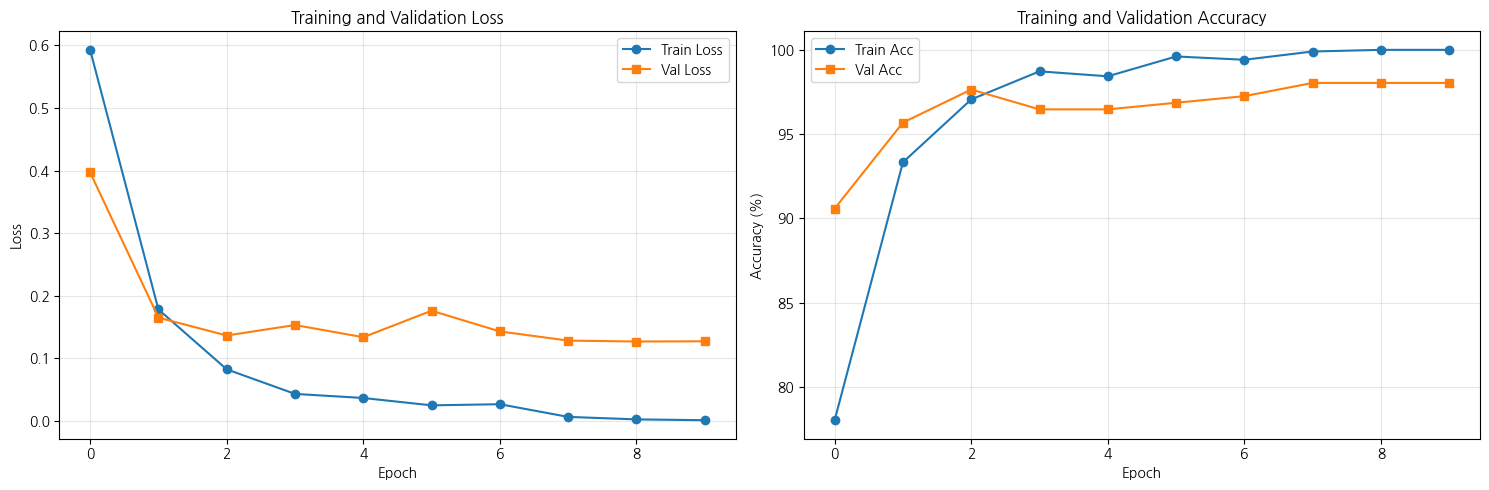

In [ ]:
print("=" * 70)
print("학습 과정 시각화")
print("=" * 70)

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss 그래프
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Accuracy 그래프
axes[1].plot(history['train_acc'], label='Train Acc', marker='o')
axes[1].plot(history['val_acc'], label='Val Acc', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 11. 모델 평가

In [ ]:
print("=" * 70)
print("최종 모델 평가")
print("=" * 70)

# Test 데이터로 최종 평가
test_loss, test_acc, y_pred, y_true = evaluate(
    model, test_loader, criterion, device
)

print(f"\n[Test 성능]")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.2f}%")

# F1-Score 계산
from sklearn.metrics import f1_score
f1_macro = f1_score(y_true, y_pred, average='macro')
f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"  F1-Score (macro): {f1_macro:.4f}")
print(f"  F1-Score (weighted): {f1_weighted:.4f}")

최종 모델 평가

[Test 성능]
  Loss: 0.1273
  Accuracy: 98.04%
  F1-Score (macro): 0.9719
  F1-Score (weighted): 0.9804


## 12. 상세 분류 리포트

In [ ]:
print("=" * 70)
print("분류 리포트")
print("=" * 70)

# 레이블 이름으로 변환
y_true_labels = [idx2label[idx] for idx in y_true]
y_pred_labels = [idx2label[idx] for idx in y_pred]

# Classification Report
print("\n상세 리포트:")
print(classification_report(y_true_labels, y_pred_labels))

분류 리포트

상세 리포트:
              precision    recall  f1-score   support

        경과관찰       1.00      0.98      0.99        91
          정상       0.98      1.00      0.99        98
      즉시치료필요       0.94      0.97      0.96        34
      추가검사필요       0.97      0.94      0.95        32

    accuracy                           0.98       255
   macro avg       0.97      0.97      0.97       255
weighted avg       0.98      0.98      0.98       255



## 13. Confusion Matrix

Confusion Matrix


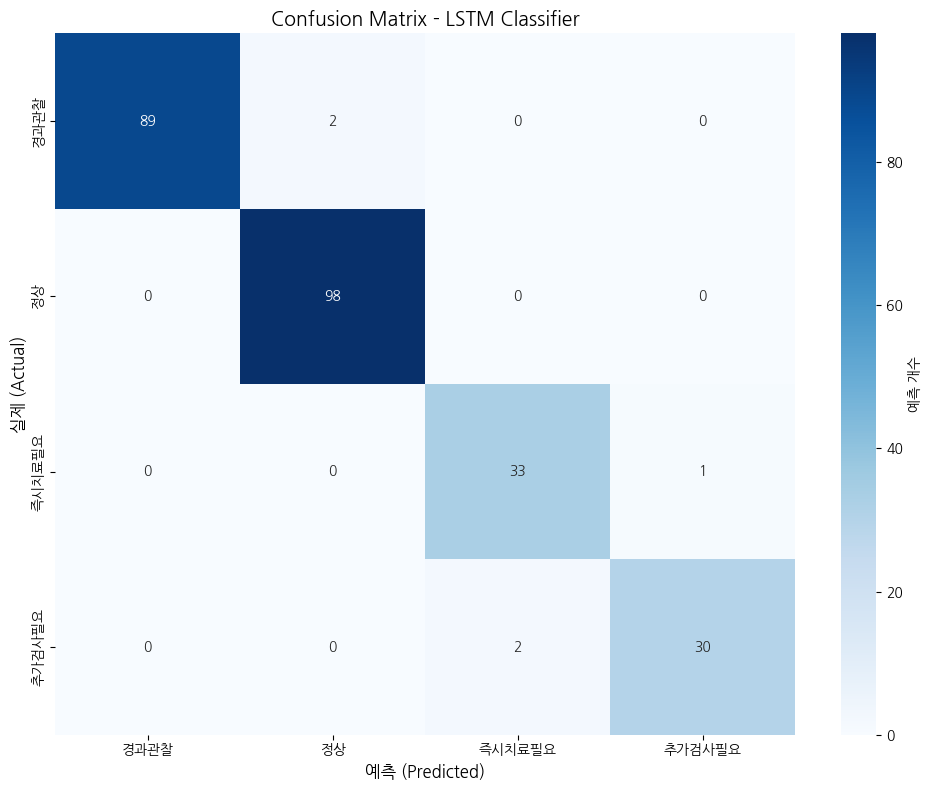

In [ ]:
print("=" * 70)
print("Confusion Matrix")
print("=" * 70)

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)

# 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=[idx2label[i] for i in range(len(idx2label))],
    yticklabels=[idx2label[i] for i in range(len(idx2label))],
    cbar_kws={'label': '예측 개수'}
)
plt.xlabel('예측 (Predicted)', fontsize=12)
plt.ylabel('실제 (Actual)', fontsize=12)
plt.title('Confusion Matrix - LSTM Classifier', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---

## 14. Hidden States 분석

LSTM의 마지막 hidden state를 추출하여 시각화합니다.

**분석 목표**:
- Hidden state가 어떻게 클래스를 구분하는지 확인
- t-SNE로 2차원 시각화

In [ ]:
print("=" * 70)
print("Hidden States 추출")
print("=" * 70)

def extract_hidden_states(model, dataloader, device):
    """모든 샘플의 hidden state 추출"""
    model.eval()

    all_hidden = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)

            # Forward
            _, hidden = model(inputs)

            all_hidden.append(hidden.cpu().numpy())
            all_labels.extend(labels.numpy())

    all_hidden = np.vstack(all_hidden)
    all_labels = np.array(all_labels)

    return all_hidden, all_labels

# Hidden states 추출
hidden_states, labels = extract_hidden_states(model, test_loader, device)

print(f"\nHidden states shape: {hidden_states.shape}")
print(f"Labels shape: {labels.shape}")

Hidden States 추출

Hidden states shape: (255, 512)
Labels shape: (255,)


In [ ]:
# t-SNE로 차원 축소
from sklearn.manifold import TSNE

print("\nt-SNE 차원 축소 중...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
hidden_2d = tsne.fit_transform(hidden_states)

print(f"축소된 shape: {hidden_2d.shape}")


t-SNE 차원 축소 중...
축소된 shape: (255, 2)


Hidden States 시각화 (t-SNE)


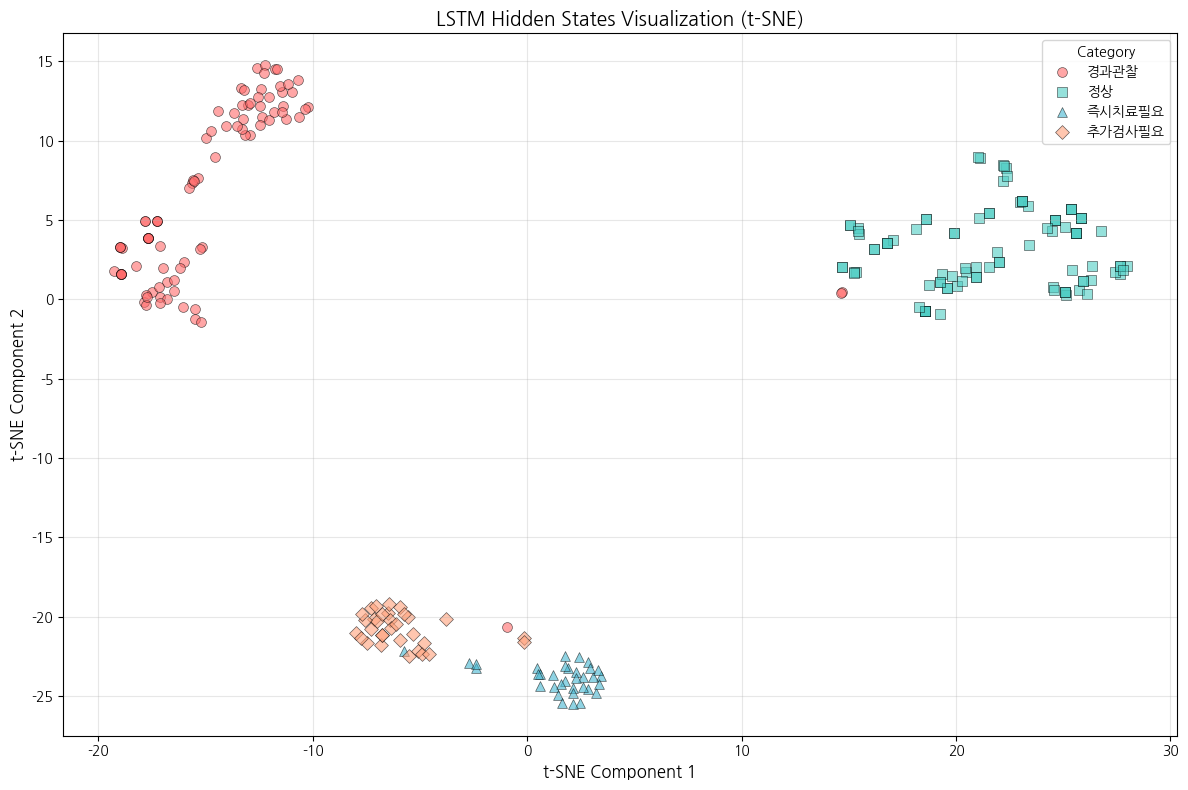


✓ Hidden states가 클래스별로 잘 분리되어 있으면 모델이 잘 학습된 것입니다.


In [ ]:
# 시각화
print("=" * 70)
print("Hidden States 시각화 (t-SNE)")
print("=" * 70)

plt.figure(figsize=(12, 8))

# 클래스별로 다른 색상
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
markers = ['o', 's', '^', 'D']

for idx, label_name in idx2label.items():
    mask = labels == idx
    plt.scatter(
        hidden_2d[mask, 0],
        hidden_2d[mask, 1],
        c=colors[idx],
        marker=markers[idx],
        label=label_name,
        alpha=0.6,
        s=50,
        edgecolors='black',
        linewidth=0.5
    )

plt.xlabel('t-SNE Component 1', fontsize=12)
plt.ylabel('t-SNE Component 2', fontsize=12)
plt.title('LSTM Hidden States Visualization (t-SNE)', fontsize=14, fontweight='bold')
plt.legend(title='Category', fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print("\n✓ Hidden states가 클래스별로 잘 분리되어 있으면 모델이 잘 학습된 것입니다.")

---

## 15. 전통적 ML 모델과 비교

Logistic Regression, Naive Bayes, SVM과 성능을 비교합니다.

In [ ]:
print("=" * 70)
print("전통적 ML 모델과 비교")
print("=" * 70)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# TF-IDF 벡터화
print("\nTF-IDF 벡터화 중...")
vectorizer = TfidfVectorizer(max_features=1000, ngram_range=(1, 2))
X_train_tfidf = vectorizer.fit_transform(X_train_texts)
X_test_tfidf = vectorizer.transform(X_test_texts)

# 모델 학습 및 평가
ml_results = {}

# Logistic Regression
print("\nLogistic Regression 학습 중...")
lr = LogisticRegression(max_iter=1000, random_state=42)
lr.fit(X_train_tfidf, y_train)
lr_acc = lr.score(X_test_tfidf, y_test) * 100
lr_f1 = f1_score(y_test, lr.predict(X_test_tfidf), average='macro')
ml_results['Logistic Regression'] = {'accuracy': lr_acc, 'f1': lr_f1}

# Naive Bayes
print("Naive Bayes 학습 중...")
nb = MultinomialNB(alpha=0.1)
nb.fit(X_train_tfidf, y_train)
nb_acc = nb.score(X_test_tfidf, y_test) * 100
nb_f1 = f1_score(y_test, nb.predict(X_test_tfidf), average='macro')
ml_results['Naive Bayes'] = {'accuracy': nb_acc, 'f1': nb_f1}

# SVM
print("SVM 학습 중...")
svm = LinearSVC(max_iter=1000, random_state=42)
svm.fit(X_train_tfidf, y_train)
svm_acc = svm.score(X_test_tfidf, y_test) * 100
svm_f1 = f1_score(y_test, svm.predict(X_test_tfidf), average='macro')
ml_results['Linear SVM'] = {'accuracy': svm_acc, 'f1': svm_f1}

# LSTM 결과 추가
ml_results['LSTM (Word)'] = {'accuracy': test_acc, 'f1': f1_macro}

# 결과 출력
print("\n" + "=" * 70)
print("모델 성능 비교")
print("=" * 70)

comparison_df = pd.DataFrame(ml_results).T
comparison_df.columns = ['Accuracy (%)', 'F1-Score']

print("\n성능 비교표:\n")
print(comparison_df.to_string())

# 최고 성능 모델
best_model = comparison_df['Accuracy (%)'].idxmax()
print(f"\n🏆 최고 성능 모델: {best_model}")
print(f"   Accuracy: {comparison_df.loc[best_model, 'Accuracy (%)']:.2f}%")
print(f"   F1-Score: {comparison_df.loc[best_model, 'F1-Score']:.4f}")

전통적 ML 모델과 비교

TF-IDF 벡터화 중...

Logistic Regression 학습 중...
Naive Bayes 학습 중...
SVM 학습 중...

모델 성능 비교

성능 비교표:

                     Accuracy (%)  F1-Score
Logistic Regression     97.647059  0.960076
Naive Bayes             96.078431  0.940181
Linear SVM              98.431373  0.971635
LSTM (Word)             98.039216  0.971923

🏆 최고 성능 모델: Linear SVM
   Accuracy: 98.43%
   F1-Score: 0.9716


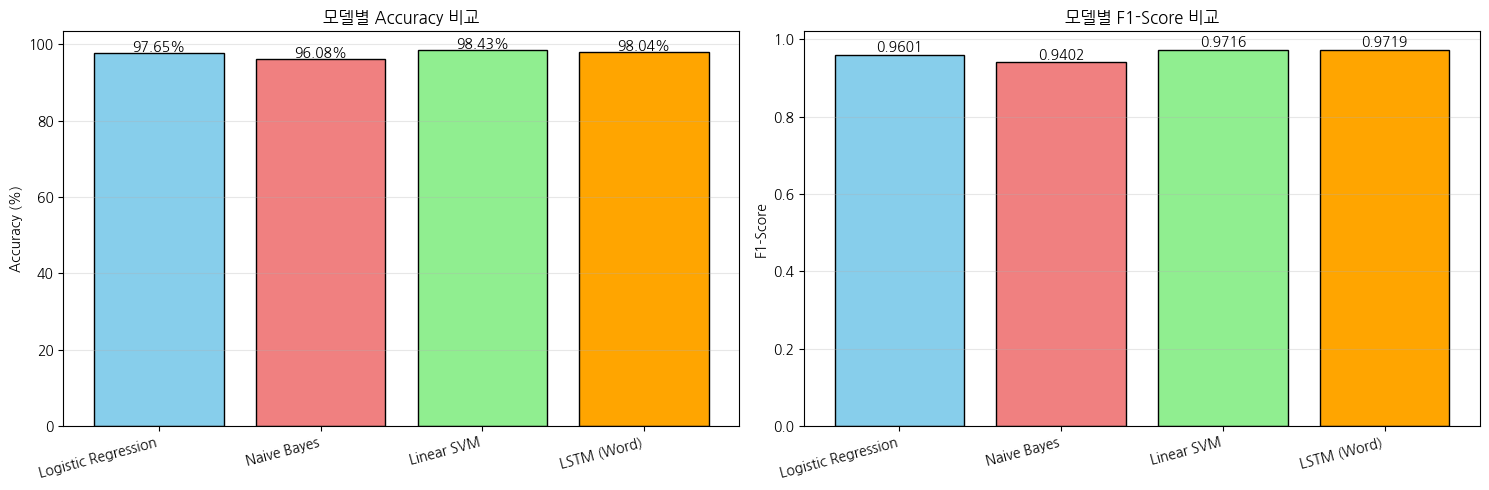

In [ ]:
# 시각화
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy 비교
axes[0].bar(
    range(len(comparison_df)),
    comparison_df['Accuracy (%)'],
    color=['skyblue', 'lightcoral', 'lightgreen', 'orange'],
    edgecolor='black'
)
axes[0].set_xticks(range(len(comparison_df)))
axes[0].set_xticklabels(comparison_df.index, rotation=15, ha='right')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title('모델별 Accuracy 비교', fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# 수치 표시
for i, v in enumerate(comparison_df['Accuracy (%)']):
    axes[0].text(i, v + 0.5, f'{v:.2f}%', ha='center', fontsize=10)

# F1-Score 비교
axes[1].bar(
    range(len(comparison_df)),
    comparison_df['F1-Score'],
    color=['skyblue', 'lightcoral', 'lightgreen', 'orange'],
    edgecolor='black'
)
axes[1].set_xticks(range(len(comparison_df)))
axes[1].set_xticklabels(comparison_df.index, rotation=15, ha='right')
axes[1].set_ylabel('F1-Score')
axes[1].set_title('모델별 F1-Score 비교', fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

# 수치 표시
for i, v in enumerate(comparison_df['F1-Score']):
    axes[1].text(i, v + 0.01, f'{v:.4f}', ha='center', fontsize=10)

plt.tight_layout()
plt.show()

---

## 16. 실전 예측 테스트

In [ ]:
print("=" * 70)
print("실전 예측 테스트")
print("=" * 70)

def predict_text(model, text, word2idx, device, max_len=100):
    """새로운 텍스트 예측"""
    model.eval()

    # 시퀀스 변환
    sequence = text_to_sequence(text, word2idx, max_len)
    sequence_tensor = torch.LongTensor([sequence]).to(device)

    with torch.no_grad():
        output, hidden = model(sequence_tensor)
        probs = torch.softmax(output, dim=1)
        pred_idx = torch.argmax(probs, dim=1).item()

    return pred_idx, probs.cpu().numpy()[0], hidden.cpu().numpy()[0]

# 새로운 판독문 샘플
new_samples = [
    "양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다.",
    "우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다.",
    "좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다.",
    "우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다.",
    "간 우엽에 약 2.5cm 크기의 종괴가 관찰됩니다. 간세포암 의심. 즉시 진료가 필요합니다."
]

print("\n새로운 판독문 예측 결과:\n")

for i, text in enumerate(new_samples):
    pred_idx, probs, hidden = predict_text(model, text, word2idx, device)
    pred_label = idx2label[pred_idx]

    print(f"[샘플 {i+1}]")
    print(f"  판독문: {text[:70]}...")
    print(f"  예측: {pred_label} (신뢰도: {probs[pred_idx]*100:.1f}%)")
    print(f"  확률 분포:")
    for idx, prob in enumerate(probs):
        label = idx2label[idx]
        bar = '█' * int(prob * 20)
        print(f"    {label:15s}: {bar} {prob*100:.1f}%")
    print()

실전 예측 테스트

새로운 판독문 예측 결과:

[샘플 1]
  판독문: 양측 폐야는 전반적으로 깨끗합니다. 심장 크기는 정상 범위입니다. 특이 소견 없습니다....
  예측: 정상 (신뢰도: 99.2%)
  확률 분포:
    경과관찰           :  0.0%
    정상             : ███████████████████ 99.2%
    즉시치료필요         :  0.4%
    추가검사필요         :  0.3%

[샘플 2]
  판독문: 우측 폐상엽에 약 6mm 크기의 미세 결절이 관찰됩니다. 1년 후 추적 검사 권장합니다....
  예측: 경과관찰 (신뢰도: 99.8%)
  확률 분포:
    경과관찰           : ███████████████████ 99.8%
    정상             :  0.0%
    즉시치료필요         :  0.0%
    추가검사필요         :  0.2%

[샘플 3]
  판독문: 좌하엽에 경화 소견이 있습니다. 폐렴 의심. 항생제 치료 권장합니다....
  예측: 즉시치료필요 (신뢰도: 99.6%)
  확률 분포:
    경과관찰           :  0.2%
    정상             :  0.0%
    즉시치료필요         : ███████████████████ 99.6%
    추가검사필요         :  0.2%

[샘플 4]
  판독문: 우측 폐중엽에 약 12mm 크기의 결절이 관찰됩니다. 추가 정밀검사가 필요합니다....
  예측: 추가검사필요 (신뢰도: 93.7%)
  확률 분포:
    경과관찰           : █ 5.3%
    정상             :  0.0%
    즉시치료필요         :  1.0%
    추가검사필요         : ██████████████████ 93.7%

[샘플 5]
  판독문: 간 우엽에 약 2.5cm 크기의 종괴가 관찰됩니다. 간세포암 의심. 즉시 진료가 필요합니다....
  

---

## 17. 오분류 사례 분석

In [ ]:
print("=" * 70)
print("오분류 사례 분석")
print("=" * 70)

# 오분류된 샘플 찾기
y_pred_array = np.array(y_pred)
y_true_array = np.array(y_true)
misclassified_idx = np.where(y_pred_array != y_true_array)[0]

print(f"\n오분류 개수: {len(misclassified_idx)}건 ({len(misclassified_idx)/len(y_true)*100:.1f}%)")

if len(misclassified_idx) > 0:
    print("\n오분류 샘플 (상위 5개):\n")

    for i, idx in enumerate(misclassified_idx[:5]):
        text = X_test_texts[idx]
        true_label = idx2label[y_true_array[idx]]
        pred_label = idx2label[y_pred_array[idx]]

        # 예측 확률 계산
        _, probs, _ = predict_text(model, text, word2idx, device)

        print(f"[오분류 {i+1}]")
        print(f"  텍스트: {text[:100]}...")
        print(f"  실제: {true_label}")
        print(f"  예측: {pred_label} (신뢰도: {probs[y_pred_array[idx]]*100:.1f}%)")
        print()

오분류 사례 분석

오분류 개수: 5건 (2.0%)

오분류 샘플 (상위 5개):

[오분류 1]
  텍스트: 간 실질은 전반적으로 에코가 증가되어 있어 중등도 지방간 소견이 관찰됩니다. 담낭, 췌장, 비장, 양측 신장은 정상 소견입니다. 중등도 지방간. 체중 조절 및 정기적인 추적관찰이 ...
  실제: 경과관찰
  예측: 정상 (신뢰도: 98.0%)

[오분류 2]
  텍스트: 간 실질은 전반적으로 에코가 증가되어 있어 지방간 소견이 관찰됩니다. 담낭 내 결석이나 용종은 관찰되지 않습니다. 췌장, 비장, 양측 신장은 정상 소견입니다. 중등도 지방간. 체중...
  실제: 경과관찰
  예측: 정상 (신뢰도: 97.4%)

[오분류 3]
  텍스트: L3-4, L4-5 레벨에서 척추관 협착증이 관찰됩니다. 다분절 협착 소견입니다. 다분절 척추관 협착증. 정형외과 진료 및 치료가 필요합니다....
  실제: 즉시치료필요
  예측: 추가검사필요 (신뢰도: 97.5%)

[오분류 4]
  텍스트: 간 우엽에 약 1.5cm 크기의 결절이 관찰됩니다. 재생결절 또는 이형성결절 의심됩니다. 간 결절. 간담도내과 진료 및 추적관찰이 필요합니다....
  실제: 추가검사필요
  예측: 즉시치료필요 (신뢰도: 94.4%)

[오분류 5]
  텍스트: 총담관이 약 1.2cm로 확장되어 있습니다. 담관 하부에 작은 결석이 의심됩니다. 총담관 확장 및 담석 의심. 소화기내과 진료가 필요합니다....
  실제: 추가검사필요
  예측: 즉시치료필요 (신뢰도: 93.1%)



---

## Summary

본 노트북에서는 의료 판독문 텍스트를 분류하기 위해 **Word-level Tokenization 기반의 LSTM 모델**을 구축하고 평가했습니다.

### 주요 과정 및 결과:

1.  **데이터 다운로드 및 환경 설정**: Colab 환경에서 필요한 데이터를 다운로드하고 한글 폰트를 설정했습니다.
2.  **라이브러리 로드**: `pandas`, `numpy`, `matplotlib`, `seaborn`, `torch`, `sklearn` 등 필요한 라이브러리를 임포트했습니다.
3.  **데이터 로드 및 탐색**: 1,275건의 의료 판독문 데이터를 로드하고, `findings`와 `impression` 컬럼을 결합하여 `text` 컬럼을 생성했습니다. 텍스트 길이 분포를 시각화하여 확인했습니다.
4.  **Word-level Tokenization**: 공백을 기준으로 단어를 분리하여 Vocabulary를 구축하고, 단어를 인덱스 시퀀스로 변환하는 함수를 정의했습니다. Vocabulary 크기는 889개였습니다.
5.  **데이터셋 준비**: `train_test_split`을 통해 데이터를 학습/테스트 세트로 분할하고, `PyTorch Dataset`과 `DataLoader`를 정의했습니다. 시퀀스 길이를 95 percentile에 맞춰 `MAX_LEN=22`로 설정했습니다.
6.  **LSTM 모델 정의**: Word Embedding Layer, Bidirectional LSTM Layer (hidden_dim=256, n_layers=2), Dropout, Fully Connected Layer로 구성된 `WordLSTMClassifier` 모델을 정의했습니다. 총 학습 가능한 파라미터는 약 248만개였습니다.
7.  **학습 준비**: `CrossEntropyLoss`를 Loss function으로, `Adam`을 Optimizer로 설정하고 `ReduceLROnPlateau` 스케줄러를 적용했습니다.
8.  **모델 학습**: 10 에포크 동안 모델을 학습했습니다. 최종 검증 정확도는 **98.04%**를 기록했습니다.
9.  **학습 과정 시각화**: 에포크별 Train/Validation Loss와 Accuracy 변화를 그래프로 확인했습니다.
10. **모델 평가**: Test 데이터셋에 대한 최종 성능은 Loss **0.1273**, Accuracy **98.04%**, F1-Score (macro) **0.9719**로 매우 높은 성능을 보였습니다.
11. **상세 분류 리포트 및 Confusion Matrix**: 각 카테고리별 정밀도, 재현율, F1-Score를 확인하고 Confusion Matrix를 통해 모델의 예측 경향을 시각적으로 분석했습니다.
12. **Hidden States 분석**: t-SNE를 이용하여 LSTM의 마지막 Hidden State를 2차원으로 시각화했습니다. 클래스별로 Hidden State가 잘 분리되는 것을 확인하여 모델이 효과적으로 특징을 학습했음을 보였습니다.
13. **전통적 ML 모델과 비교**: TF-IDF 벡터화 후 Logistic Regression, Naive Bayes, Linear SVM 모델과 성능을 비교했습니다. Linear SVM이 98.43%의 정확도로 근소하게 가장 높았고, LSTM 모델은 98.04%로 유사하게 우수한 성능을 보였습니다.
14. **실전 예측 테스트**: 새로운 판독문 샘플에 대해 모델이 정확하게 카테고리를 예측하고 확률 분포를 제시하는 것을 확인했습니다.
15. **오분류 사례 분석**: Test 데이터셋에서 오분류된 5건의 샘플을 분석하여 모델의 한계점과 예측 경향을 이해했습니다.

결론적으로, Word-level LSTM 모델은 의료 판독문 분류 태스크에서 높은 성능을 달성했으며, 전통적인 ML 모델들과 비교해서도 경쟁력 있는 결과를 보였습니다. Hidden State 분석을 통해 모델이 각 클래스를 구분하는 특징을 잘 학습했음을 시각적으로 확인할 수 있었습니다.